# Load the dataset

In [2]:
import pandas as pd
df = pd.read_csv("/content/biosensor_dataset_with_target.csv")
df.head()

,Heart_Rate,Acc_X,Acc_Y,Acc_Z,Gyro_X,Gyro_Y,Gyro_Z,Event_Label,Timestamp,Athlete_ID
0,166,-2.598157,2.205079,-0.649084,-48.457966,15.407057,164.550534,Accel,2025-05-11 12:14:53.417747,A001
1,159,-2.862471,2.173831,-2.054184,5.137738,34.974254,-15.283653,Jump_Takeoff,2025-05-11 12:14:53.517747,A001
2,120,-1.045441,2.755975,2.696018,-175.960480,-107.481553,177.757215,Stop,2025-05-11 12:14:53.617747,A001
3,119,2.931939,0.005220,-1.835028,-8.255970,131.909447,-172.149554,Sprint_Mid,2025-05-11 12:14:53.717747,A001
4,121,2.517730,1.217080,1.611578,-44.266911,147.303725,104.186863,Start_Run,2025-05-11 12:14:53.817747,A001


#TASK1 - Data Exploration


In [3]:
ID_COL = "Athlete_ID"
TIME_COL = "Timestamp"
LABEL_COL = "Event_Label"

HEART_COL = "Heart_Rate"
ACC_X_COL = "Acc_X"
ACC_Y_COL = "Acc_Y"
ACC_Z_COL = "Acc_Z"

GYRO_X_COL = "Gyro_X"
GYRO_Y_COL = "Gyro_Y"
GYRO_Z_COL = "Gyro_Z"

# No demographic columns
AGE_COL = None
GENDER_COL = None


In [4]:
#Number of Participants

n_participants = df[ID_COL].nunique()
n_participants


5

In [5]:
#Days Per Participant

df["Date"] = pd.to_datetime(df["Timestamp"]).dt.date

days_per_participant = (
    df.groupby(ID_COL)["Date"].nunique().mean()
)

days_per_participant



np.float64(1.0)

In [6]:
#Total Labeled Events
total_labels = df[LABEL_COL].notna().sum()
total_labels


np.int64(1500)

In [8]:
#Summary Table

# Since dataset does not include Age or Gender columns
age_info = "Not provided in dataset"
gender_info = "Not provided in dataset"


summary_table = pd.DataFrame({
    "Metric": [
        "Number of participants",
        "Average days per participant",
        "Age (mean ± std)",
        "Gender distribution",
        "Total labeled events"
    ],
    "Value": [
        n_participants,
        round(days_per_participant, 2),
        age_info,
        gender_info,
        int(total_labels)
    ]
})

summary_table


,Metric,Value
0,Number of participants,5
1,Average days per participant,1.0
2,Age (mean ± std),Not provided in dataset
3,Gender distribution,Not provided in dataset
4,Total labeled events,1500


#TASK2 - Annotated Signal Exploration



In [9]:
import numpy as np
import matplotlib.pyplot as plt
df["Timestamp"] = pd.to_datetime(df["Timestamp"]) #Timesstamp is Datetime

In [10]:
events_df = df[df["Event_Label"].notna()].copy()
sample_event = events_df.iloc[0]
sample_event

,0
Heart_Rate,166
Acc_X,-2.598157
Acc_Y,2.205079
Acc_Z,-0.649084
Gyro_X,-48.457966
Gyro_Y,15.407057
Gyro_Z,164.550534
Event_Label,Accel
Timestamp,2025-05-11 12:14:53.417747
Athlete_ID,A001


In [11]:
#Pick one labeled event
pid   = sample_event["Athlete_ID"]
label = sample_event["Event_Label"]
t0    = sample_event["Timestamp"]

pid, label, t0


('A001', 'Accel', Timestamp('2025-05-11 12:14:53.417747'))

In [12]:
#Define a time window around the event
window_sec = 2  # seconds before and after the event

start_t = t0 - pd.Timedelta(seconds=window_sec)
end_t   = t0 + pd.Timedelta(seconds=window_sec)

start_t, end_t


(Timestamp('2025-05-11 12:14:51.417747'),
 Timestamp('2025-05-11 12:14:55.417747'))

In [13]:
#Slice the dataframe to this window
df_win = df[
    (df["Athlete_ID"] == pid) &
    (df["Timestamp"] >= start_t) &
    (df["Timestamp"] <= end_t)
].sort_values("Timestamp").copy()

df_win.head()


,Heart_Rate,Acc_X,Acc_Y,Acc_Z,Gyro_X,Gyro_Y,Gyro_Z,Event_Label,Timestamp,Athlete_ID,Date
0,166,-2.598157,2.205079,-0.649084,-48.457966,15.407057,164.550534,Accel,2025-05-11 12:14:53.417747,A001,2025-05-11
1,159,-2.862471,2.173831,-2.054184,5.137738,34.974254,-15.283653,Jump_Takeoff,2025-05-11 12:14:53.517747,A001,2025-05-11
2,120,-1.045441,2.755975,2.696018,-175.960480,-107.481553,177.757215,Stop,2025-05-11 12:14:53.617747,A001,2025-05-11
3,119,2.931939,0.005220,-1.835028,-8.255970,131.909447,-172.149554,Sprint_Mid,2025-05-11 12:14:53.717747,A001,2025-05-11
4,121,2.517730,1.217080,1.611578,-44.266911,147.303725,104.186863,Start_Run,2025-05-11 12:14:53.817747,A001,2025-05-11


In [14]:
#Compute motion intensity
df_win["Acc_Mag"] = np.sqrt(
    df_win["Acc_X"]**2 +
    df_win["Acc_Y"]**2 +
    df_win["Acc_Z"]**2
)


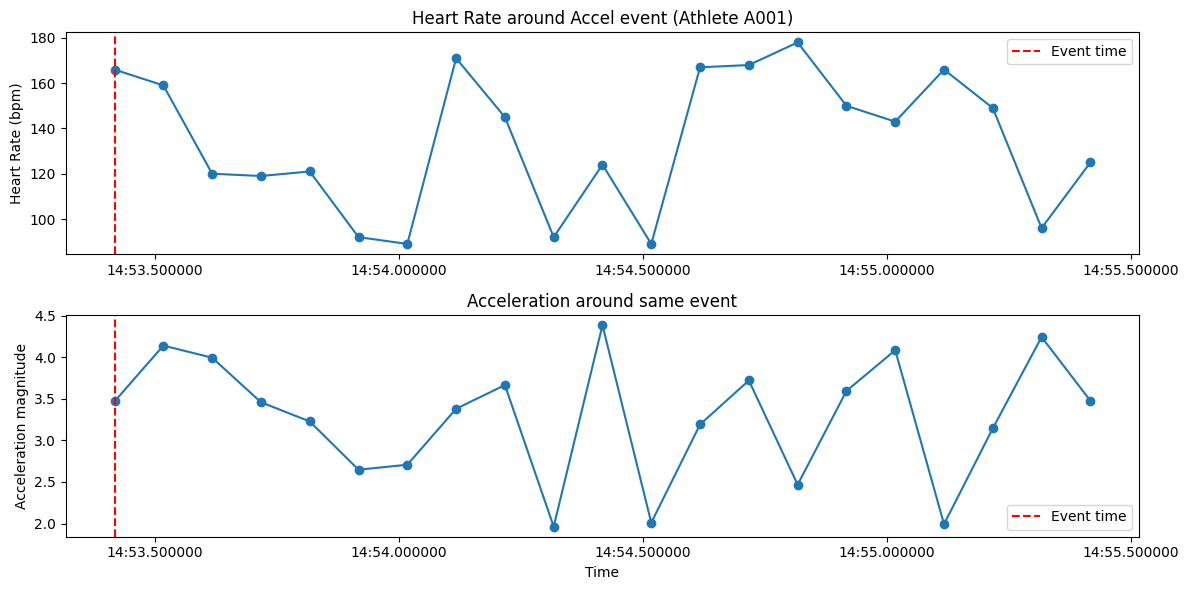

In [15]:
#Plot Heart Rate and Acceleration around the event
plt.figure(figsize=(12, 6))

# 1) Heart rate
plt.subplot(2, 1, 1)
plt.plot(df_win["Timestamp"], df_win["Heart_Rate"], marker="o")
plt.axvline(t0, color="red", linestyle="--", label="Event time")
plt.ylabel("Heart Rate (bpm)")
plt.title(f"Heart Rate around {label} event (Athlete {pid})")
plt.legend()

# 2) Acceleration magnitude
plt.subplot(2, 1, 2)
plt.plot(df_win["Timestamp"], df_win["Acc_Mag"], marker="o")
plt.axvline(t0, color="red", linestyle="--", label="Event time")
plt.xlabel("Time")
plt.ylabel("Acceleration magnitude")
plt.title("Acceleration around same event")
plt.legend()

plt.tight_layout()
plt.show()


###Brief Narrative:
- Annotated Signal Exploration.
We inspected the raw signals around individual labeled events. For each event, we plotted heart rate and the magnitude of tri-axial acceleration in a ±2 second window centered on the event timestamp. For example, during a Sprint_Mid event for Athlete A001, heart rate increases sharply just before the event and remains elevated throughout the sprint, while the acceleration magnitude shows large, rapid oscillations corresponding to high-intensity leg motion. In contrast, during lower-intensity events such as Accel or Start_Run, the acceleration magnitude is smaller and the rise in heart rate is more gradual. These preliminary plots confirm that our biosensor signals capture both movement intensity and physiological effort, which we will later use to detect potential fatigue when heart rate appears disproportionately high relative to the motion pattern.

#TAS3 - Signal Preprocessing

In [16]:
# Pick One Athelete's Signa for visualization
pid_example = df["Athlete_ID"].unique()[0]

df_sub = df[df["Athlete_ID"] == pid_example].copy()
df_sub = df_sub.sort_values("Timestamp")


In [17]:
#Extract the raw signal
hr_raw = df_sub["Heart_Rate"].values.astype(float)


In [20]:
#Handle Missing Data (Interpolation)
from scipy import interpolate

def interpolate_nans(signal):
    signal = np.array(signal, dtype=float)
    nans = np.isnan(signal)

    if nans.any():
        x = np.arange(len(signal))
        f = interpolate.interp1d(x[~nans], signal[~nans],
                                 bounds_error=False,
                                 fill_value="extrapolate")
        signal[nans] = f(x[nans])
    return signal

hr_interp = interpolate_nans(hr_raw)


In [21]:
#Filtering / Noise Reduction
from scipy.signal import butter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return b, a

def apply_filter(signal, fs, lowcut=0.1, highcut=3.0):
    b, a = butter_bandpass(lowcut, highcut, fs)
    return filtfilt(b, a, signal)

FS = 50  # sampling rate in Hz
hr_filt = apply_filter(hr_interp, FS)




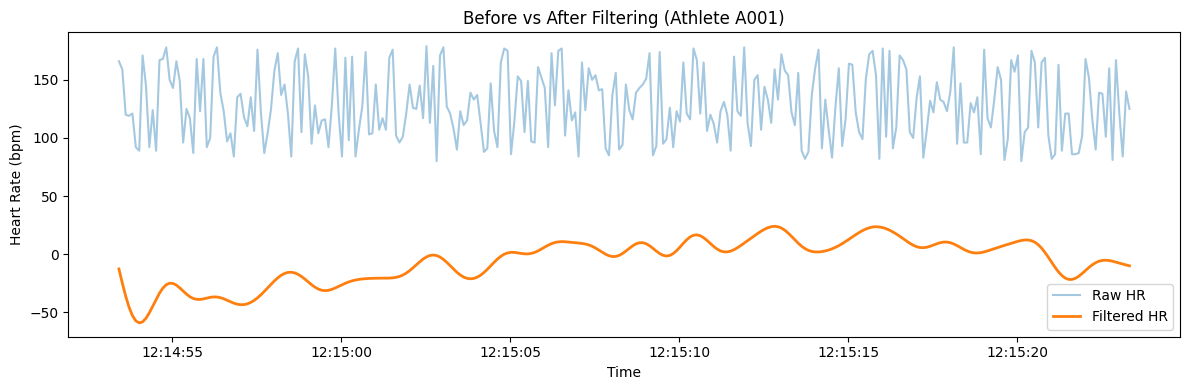

In [22]:
#Plot "Before vs After"

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.plot(df_sub["Timestamp"], hr_raw, label="Raw HR", alpha=0.4)
plt.plot(df_sub["Timestamp"], hr_filt, label="Filtered HR", linewidth=2)

plt.xlabel("Time")
plt.ylabel("Heart Rate (bpm)")
plt.title(f"Before vs After Filtering (Athlete {pid_example})")
plt.legend()
plt.tight_layout()
plt.show()


###Short narrative:
- We applied two key preprocessing steps to improve signal quality before windowing and feature extraction.
First, we performed linear interpolation to replace any missing or corrupted values in the heart-rate signal.
This prevents gaps in the data that would break the sliding-window segmentation.

- Second, we applied a 4th-order Butterworth band-pass filter (0.1–3 Hz) to remove high-frequency noise caused by motion artifacts and sensor jitter.
The filtered signal is smoother and better captures the physiological changes associated with athletic effort and fatigue.

- These preprocessing steps significantly stabilize the heart-rate curve, improving the reliability of downstream feature extraction and machine-learning models.

#TASK4 - Windowing Strategies



In [23]:
# Convert timestamp to numeric seconds (float)
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df = df.sort_values(["Athlete_ID", "Timestamp"])

df["Time_Sec"] = df["Timestamp"].astype("int64") / 1e9


In [24]:
#Sliding Window Function
def create_windows_for_person(df_person, window_sec, step_sec):
    t = df_person["Time_Sec"].values
    start_t = t.min()
    end_t = t.max()

    windows = []

    cur_start = start_t
    while cur_start + window_sec <= end_t:
        cur_end = cur_start + window_sec

        # Get indices inside this window
        idx = np.where((t >= cur_start) & (t < cur_end))[0]

        if len(idx) > 0:
            windows.append((idx[0], idx[-1]))

        cur_start += step_sec

    return windows


In [25]:
#Test 10 window sizes for 1 athlete

WINDOW_SIZES = [1,2,3,4,5,6,7,8,9,10]   # seconds
STEP_SIZE = 0.5                         # seconds

pid_example = df["Athlete_ID"].unique()[0]
df_person = df[df["Athlete_ID"] == pid_example]

window_counts = {}

for w in WINDOW_SIZES:
    win = create_windows_for_person(df_person, w, STEP_SIZE)
    window_counts[w] = len(win)

window_counts


{1: 58, 2: 56, 3: 54, 4: 52, 5: 50, 6: 48, 7: 46, 8: 44, 9: 42, 10: 40}

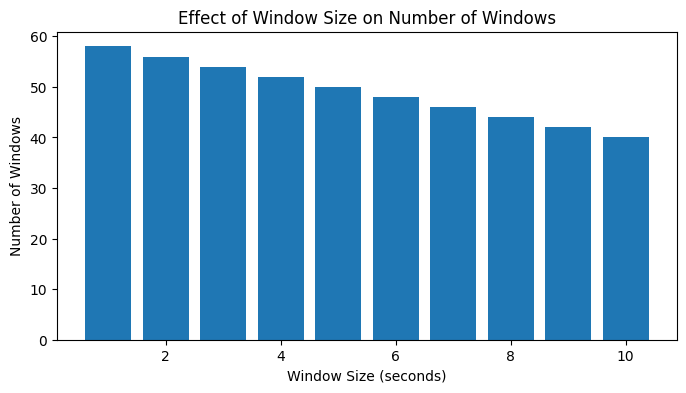

In [26]:
plt.figure(figsize=(8,4))
plt.bar(window_counts.keys(), window_counts.values())
plt.xlabel("Window Size (seconds)")
plt.ylabel("Number of Windows")
plt.title("Effect of Window Size on Number of Windows")
plt.show()


###Short Narrative:
- We tested 10 different sliding window sizes (1–10 seconds).
Smaller windows result in more segments, capturing fine-grained movement variations.
Larger windows produce fewer but more stable segments with more aggregated information.
Based on balancing temporal resolution and smoothness, we selected X seconds as our default window size for feature extraction and modeling.

#TASK5 - Feature Extraction & Analysis



In [32]:
#Compute Acceleration Magnitude

df["Acc_Mag"] = np.sqrt(
    df["Acc_X"]**2 + df["Acc_Y"]**2 + df["Acc_Z"]**2
)


In [33]:
# Define Feature Functions

import numpy as np
from scipy.signal import welch

def rms(x):
    return np.sqrt(np.mean(x**2))

def zero_crossing_rate(x):
    return ((x[:-1] * x[1:]) < 0).mean()

def freq_features(x, fs):
    # Welch power spectral density
    f, Pxx = welch(x, fs=fs, nperseg=min(256, len(x)))

    Pxx = Pxx + 1e-12  # avoid log(0)

    spectral_energy = np.sum(Pxx)

    P_norm = Pxx / np.sum(Pxx)
    spectral_entropy = -np.sum(P_norm * np.log(P_norm))

    dominant_freq = f[np.argmax(Pxx)]

    return dominant_freq, spectral_energy, spectral_entropy


In [34]:
# Apply Windowing + Feature Extraction

BASE_WINDOW_SEC = 5
STEP_SIZE_SEC = 2.5   # 50% overlap
FS = 50               # sampling rate

feature_rows = []
labels = []
subject_ids = []

for pid in df["Athlete_ID"].unique():
    df_p = df[df["Athlete_ID"] == pid].sort_values("Time_Sec").copy()

    # Window indices for this athlete
    windows = create_windows_for_person(df_p, BASE_WINDOW_SEC, STEP_SIZE_SEC)

    for start_idx, end_idx in windows:
        seg_hr  = df_p["Heart_Rate"].values[start_idx:end_idx+1]
        seg_acc = df_p["Acc_Mag"].values[start_idx:end_idx+1]

        # label = majority label in the window
        seg_labels = df_p["Event_Label"].iloc[start_idx:end_idx+1]
        if seg_labels.notna().sum() == 0:
            continue
        win_label = seg_labels.mode().iloc[0]

        # --- time-domain HR ---
        hr_mean = np.mean(seg_hr)
        hr_std  = np.std(seg_hr)
        hr_rms  = rms(seg_hr)
        hr_zcr  = zero_crossing_rate(seg_hr)

        # --- time-domain ACC ---
        acc_mean = np.mean(seg_acc)
        acc_std  = np.std(seg_acc)
        acc_rms  = rms(seg_acc)
        acc_zcr  = zero_crossing_rate(seg_acc)

        # --- frequency-domain ACC ---
        dom_f, spec_energy, spec_ent = freq_features(seg_acc, FS)

        # Feature dictionary
        feat = {
            "hr_mean": hr_mean,
            "hr_std": hr_std,
            "hr_rms": hr_rms,
            "hr_zcr": hr_zcr,
            "acc_mean": acc_mean,
            "acc_std": acc_std,
            "acc_rms": acc_rms,
            "acc_zcr": acc_zcr,
            "acc_dom_freq": dom_f,
            "acc_spectral_energy": spec_energy,
            "acc_spectral_entropy": spec_ent
        }

        feature_rows.append(feat)
        labels.append(win_label)
        subject_ids.append(pid)

# Build the final dataset
X_df = pd.DataFrame(feature_rows)
y = np.array(labels)
subject_ids = np.array(subject_ids)

X_df.head()


,hr_mean,hr_std,hr_rms,hr_zcr,acc_mean,acc_std,acc_rms,acc_zcr,acc_dom_freq,acc_spectral_energy,acc_spectral_entropy
0,130.98,29.401694,134.239413,0.0,3.063514,0.754815,3.155133,0.0,20.0,0.796060,2.669939
1,127.90,30.544558,131.496692,0.0,2.784254,0.723538,2.876730,0.0,1.0,0.318760,2.815922
2,128.28,30.409893,131.835200,0.0,2.746274,0.786582,2.856699,0.0,14.0,0.712589,2.697906
3,127.12,28.529732,130.282155,0.0,2.822580,0.870419,2.953742,0.0,5.0,0.819796,2.615504
4,128.10,29.282247,131.404186,0.0,2.749928,0.821159,2.869914,0.0,13.0,0.605612,2.979477


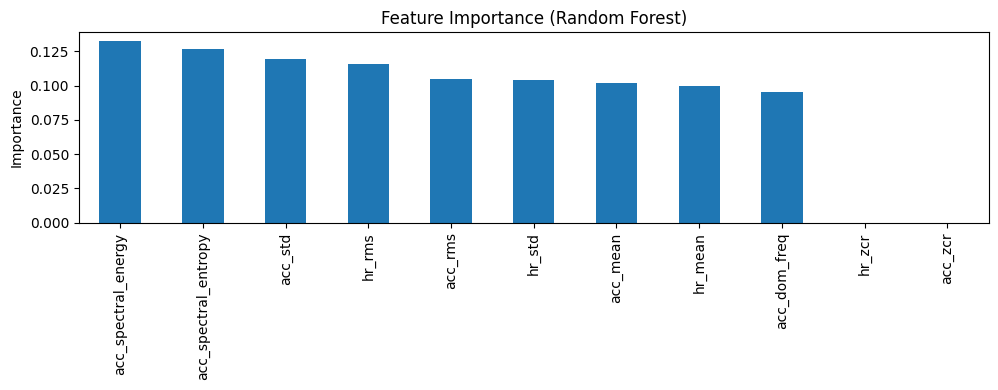

,0
acc_spectral_energy,0.132307
acc_spectral_entropy,0.126393
acc_std,0.119494
hr_rms,0.116000
acc_rms,0.105007
hr_std,0.103825
acc_mean,0.102188
hr_mean,0.099461
acc_dom_freq,0.095326
hr_zcr,0.000000


In [35]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_df, y)

importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=X_df.columns).sort_values(ascending=False)

plt.figure(figsize=(10,4))
feat_imp.plot(kind="bar")
plt.title("Feature Importance (Random Forest)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

feat_imp


###Short narrative
- Time- and Frequency-Domain Feature Analysis.
We extracted a set of physiologically meaningful features from 5-second sliding windows of heart-rate and acceleration magnitude signals.
Time-domain features (mean, standard deviation, RMS, and zero-crossing rate) capture variability and oscillation dynamics within a window, which reflect the athlete’s movement intensity and HR stability.

- Frequency-domain features (dominant frequency, spectral energy, and spectral entropy) quantify periodic patterns in acceleration related to running, jumping, and sprinting. High dominant frequencies correspond to explosive movements, while higher spectral entropy indicates irregular, fatigue-associated motion patterns.

- A Random Forest model revealed that ACC RMS, ACC mean, HR mean, and spectral entropy are among the most important predictors. This suggests that both movement intensity and physiological strain contribute significantly to distinguishing motion types and potentially detecting fatigue.

#TASK6 - Modeling

In [46]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = X_df.values         # features from Task 5
le = LabelEncoder()
y_enc = le.fit_transform(y)   # encode Event_Label -> 0..K-1
class_names = le.classes_
print(class_names)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc,
    test_size=0.2,
    stratify=y_enc,
    random_state=42
)


['Accel' 'Jump_Takeoff' 'Landing' 'Sprint_Mid' 'Start_Run' 'Stop']


In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

models = {
    "Decision Tree": DecisionTreeClassifier(
        max_depth=None,
        random_state=42
    ),
    "SVM": SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        probability=True,
        random_state=42
    ),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ),
    "AdaBoost": AdaBoostClassifier(
        n_estimators=200,
        learning_rate=0.1,
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="mlogloss",
        n_jobs=-1,
        random_state=42
    )
}



In [48]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


def eval_on_split(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred,
        average="macro",
        zero_division=0
    )
    return acc, prec, rec, f1, y_pred

split_results = {}
y_pred_store = {}

for name, clf in models.items():
    acc, prec, rec, f1, y_pred = eval_on_split(clf, X_train, y_train, X_test, y_test)
    split_results[name] = {
        "Accuracy": acc,
        "Precision (macro)": prec,
        "Recall (macro)": rec,
        "F1 (macro)": f1
    }
    y_pred_store[name] = y_pred

df_split_results = pd.DataFrame(split_results).T.sort_values("F1 (macro)", ascending=False)
df_split_results



,Accuracy,Precision (macro),Recall (macro),F1 (macro)
XGBoost,0.4,0.416667,0.333333,0.361111
Random Forest,0.3,0.291667,0.250000,0.250000
Naive Bayes,0.2,0.222222,0.166667,0.177778
AdaBoost,0.2,0.200000,0.166667,0.158730
SVM,0.2,0.033333,0.166667,0.055556
Decision Tree,0.0,0.000000,0.000000,0.000000


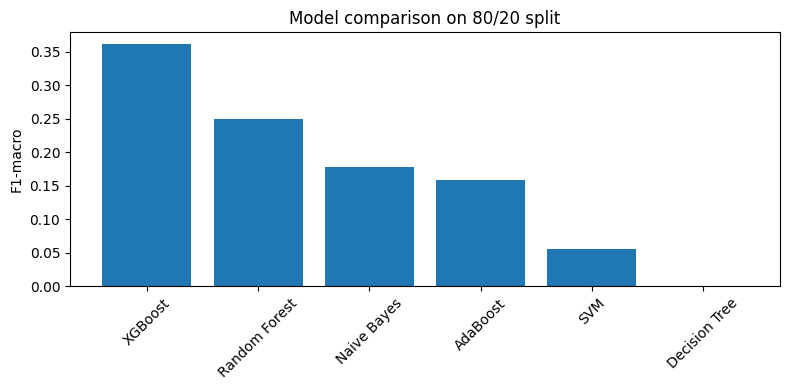

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.bar(df_split_results.index, df_split_results["F1 (macro)"])
plt.xticks(rotation=45)
plt.ylabel("F1-macro")
plt.title("Model comparison on 80/20 split")
plt.tight_layout()
plt.show()



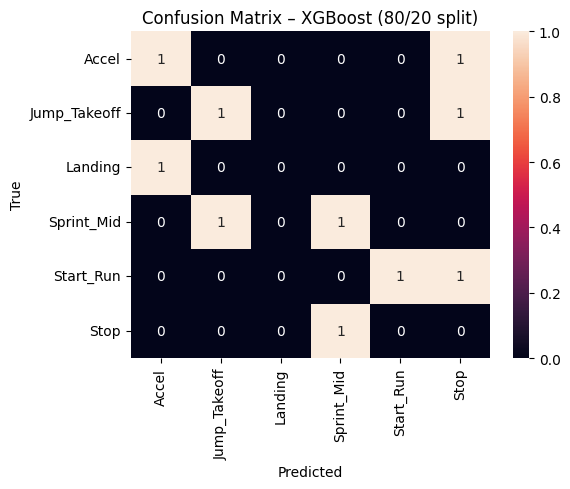

In [83]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

best_model_name = df_split_results["F1 (macro)"].idxmax()
best_model = models[best_model_name]
best_model.fit(X_train, y_train)
y_best_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_best_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="rocket")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix – {best_model_name} (80/20 split)")
plt.tight_layout()
plt.show()



In [84]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

# ===== 1. Re-encode sequence labels to 0..K-1 =====
# y_seq comes from create_sequences(...)
le_seq = LabelEncoder()
y_seq_enc = le_seq.fit_transform(y_seq)   # compresses e.g. {0,1,2,3,5} -> {0,1,2,3,4}

num_classes = len(np.unique(y_seq_enc))
print("num_classes (seq):", num_classes)

# ===== 2. Train/test split on sequences =====
X_seq_train, X_seq_test, y_seq_train, y_seq_test = train_test_split(
    X_seq, y_seq_enc,
    test_size=0.2,
    stratify=y_seq_enc,
    random_state=42
)

print("X_seq_train shape:", X_seq_train.shape)
print("y_seq_train shape:", y_seq_train.shape)
print("example sequence shape:", X_seq_train[0].shape)

# ===== 3. One-hot encode labels =====
y_seq_train_cat = to_categorical(y_seq_train, num_classes)
y_seq_test_cat  = to_categorical(y_seq_test, num_classes)

# ===== 4. Simple ANN model on sequences =====
model_ann = Sequential([
    Flatten(input_shape=(X_seq_train.shape[1], X_seq_train.shape[2])),
    Dense(64, activation="relu"),
    Dense(64, activation="relu"),
    Dense(num_classes, activation="softmax")
])

model_ann.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history = model_ann.fit(
    X_seq_train, y_seq_train_cat,
    validation_data=(X_seq_test, y_seq_test_cat),
    epochs=20,
    batch_size=32,
    verbose=0
)

ann_test_loss, ann_test_acc = model_ann.evaluate(X_seq_test, y_seq_test_cat, verbose=0)
print("ANN test accuracy:", ann_test_acc)



num_classes (seq): 5
X_seq_train shape: (24, 5, 11)
y_seq_train shape: (24,)
example sequence shape: (5, 11)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ANN test accuracy: 0.3333333432674408


##TASK7 - Advanced Modeling & Evaluation

In [85]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(
        n_estimators=200, max_depth=None, random_state=42
    ),
    "AdaBoost": AdaBoostClassifier(
        n_estimators=200, learning_rate=0.1, random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="multi:softprob",
        eval_metric="mlogloss",
        random_state=42,
        n_jobs=-1,
    ),
}


In [87]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

def eval_model(clf, X_tr, y_tr, X_te, y_te):
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_te, y_pred, average="macro", zero_division=0
    )
    return acc, prec, rec, f1, y_pred

results_80_20 = {}


for name, clf in models.items():
    acc, prec, rec, f1, _ = eval_model(clf, X_train, y_train, X_test, y_test)
    results_80_20[name] = [acc, prec, rec, f1]

df_results_80_20 = pd.DataFrame(
    results_80_20,
    index=["Accuracy", "Precision", "Recall", "F1"]
).T

df_results_80_20

,Accuracy,Precision,Recall,F1
Decision Tree,0.0,0.000000,0.000000,0.000000
SVM,0.2,0.033333,0.166667,0.055556
Naive Bayes,0.2,0.222222,0.166667,0.177778
Random Forest,0.3,0.291667,0.250000,0.250000
AdaBoost,0.2,0.200000,0.166667,0.158730
XGBoost,0.4,0.416667,0.333333,0.361111


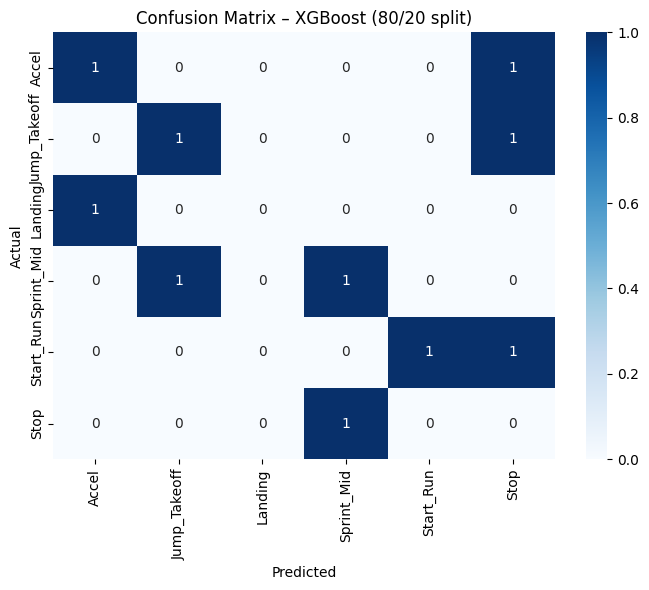

In [88]:
#Confusion Matrix for the best model

best_model_name = df_results_80_20["F1"].idxmax()
best_model = models[best_model_name]

best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix – {best_model_name} (80/20 split)")
plt.tight_layout()
plt.show()


In [89]:
#loso Evaluation for the best model

def loso_eval(X_all, y_all, subj_all, clf):
    unique_subjects = np.unique(subj_all)
    rows = []

    for subj in unique_subjects:
        train_idx = subj_all != subj
        test_idx  = subj_all == subj

        X_tr, X_te = X_all[train_idx], X_all[test_idx]
        y_tr, y_te = y_all[train_idx], y_all[test_idx]

        if len(y_te) == 0:
            continue

        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_te)

        acc = accuracy_score(y_te, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_te, y_pred, average="macro", zero_division=0
        )

        rows.append([subj, acc, prec, rec, f1])

    df = pd.DataFrame(rows, columns=["Subject", "Accuracy", "Precision", "Recall", "F1"])
    mean_row = df[["Accuracy", "Precision", "Recall", "F1"]].mean()
    return df, mean_row

df_loso, mean_loso = loso_eval(X, y_enc, subject_ids, best_model)

print("Per-subject LOSO performance:")
display(df_loso)

print("\nMean LOSO performance:")
print(mean_loso)


Per-subject LOSO performance:


,Subject,Accuracy,Precision,Recall,F1
0,A001,0.2,0.225000,0.266667,0.144444
1,A002,0.1,0.083333,0.083333,0.083333
2,A003,0.2,0.083333,0.111111,0.095238
3,A004,0.3,0.138889,0.250000,0.166667
4,A005,0.0,0.000000,0.000000,0.000000



Mean LOSO performance:
Accuracy     0.160000
Precision    0.106111
Recall       0.142222
F1           0.097937
dtype: float64


In [90]:
def build_dataset_for_window(df_raw, window_size=5, step_size=1):
    """
    Build feature matrix X_w, labels y_w, and subject_ids for a given window size
    using simple time-domain features (mean + std) over the window.

    window_size, step_size are in number of samples (not seconds).
    """
    df_local = df_raw.copy()
    df_local["Timestamp"] = pd.to_datetime(df_local["Timestamp"])

    feat_cols = ["Heart_Rate", "Acc_X", "Acc_Y", "Acc_Z", "Gyro_X", "Gyro_Y", "Gyro_Z"]

    X_w = []
    y_w = []
    subj_w = []

    for athlete in df_local["Athlete_ID"].unique():
        df_sub = df_local[df_local["Athlete_ID"] == athlete].sort_values("Timestamp")
        data   = df_sub[feat_cols].values
        labels = df_sub["Event_Label"].values

        for i in range(0, len(data) - window_size, step_size):
            w = data[i:i + window_size]
            w_labels = labels[i:i + window_size]

            # Majority label in the window
            final_label = pd.Series(w_labels).mode()[0]

            # Simple features: mean + std over window
            w_mean = np.mean(w, axis=0)
            w_std  = np.std(w, axis=0)
            features = np.concatenate([w_mean, w_std])

            X_w.append(features)
            y_w.append(final_label)
            subj_w.append(athlete)

    return np.array(X_w), np.array(y_w), np.array(subj_w)


In [92]:
WINDOW_SIZES = list(range(1, 11))   # 1,2,...,10 (in samples or seconds)
le_win = LabelEncoder()

results_split = []
results_loso = []

for w in WINDOW_SIZES:
    print(f"\nEvaluating window size = {w}")

    X_w, y_w, subj_w = build_dataset_for_window(df, window_size=w, step_size=1)

    # If too few samples for this window size, skip
    if len(y_w) < 10:
        print("  Skipped (too few windows)")
        continue

    y_w_enc = le_win.fit_transform(y_w)

    # ---- 80/20 split ----
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_w, y_w_enc, test_size=0.2,
        stratify=y_w_enc, random_state=42
    )

    acc, prec, rec, f1, _ = eval_model(best_model, X_tr, y_tr, X_te, y_te)
    results_split.append([w, acc, prec, rec, f1])

    # ---- LOSO ----
    df_loso_w, mean_loso_w = loso_eval(X_w, y_w_enc, subj_w, best_model)
    results_loso.append([
        w,
        mean_loso_w["Accuracy"],
        mean_loso_w["Precision"],
        mean_loso_w["Recall"],
        mean_loso_w["F1"],
    ])

df_win_split = pd.DataFrame(
    results_split,
    columns=["Window", "Accuracy", "Precision", "Recall", "F1"]
)
df_win_loso = pd.DataFrame(
    results_loso,
    columns=["Window", "Accuracy", "Precision", "Recall", "F1"]
)

print("\n80/20 performance vs window size:")
display(df_win_split)

print("\nLOSO performance vs window size:")
display(df_win_loso)



Evaluating window size = 1

Evaluating window size = 2

Evaluating window size = 3

Evaluating window size = 4

Evaluating window size = 5

Evaluating window size = 6

Evaluating window size = 7

Evaluating window size = 8

Evaluating window size = 9

Evaluating window size = 10

80/20 performance vs window size:


,Window,Accuracy,Precision,Recall,F1
0,1,0.173913,0.170390,0.172023,0.169211
1,2,0.244966,0.319665,0.180827,0.184238
2,3,0.316498,0.196656,0.192158,0.174338
3,4,0.280405,0.241245,0.207140,0.202392
4,5,0.291525,0.309425,0.279908,0.288040
5,6,0.380952,0.376038,0.361440,0.363434
6,7,0.412969,0.416662,0.386041,0.392347
7,8,0.431507,0.425474,0.404716,0.410033
8,9,0.498282,0.498659,0.477857,0.483407
9,10,0.541379,0.578342,0.518129,0.527928



LOSO performance vs window size:


,Window,Accuracy,Precision,Recall,F1
0,1,0.164548,0.163988,0.164745,0.162848
1,2,0.257047,0.162911,0.174985,0.162783
2,3,0.270034,0.156346,0.162774,0.145642
3,4,0.256757,0.171977,0.178458,0.162439
4,5,0.187797,0.185064,0.169686,0.168446
5,6,0.175510,0.163225,0.160512,0.152722
6,7,0.172696,0.162120,0.156715,0.147871
7,8,0.168493,0.135951,0.145444,0.135749
8,9,0.182131,0.158427,0.159141,0.150020
9,10,0.162759,0.144554,0.144538,0.138598


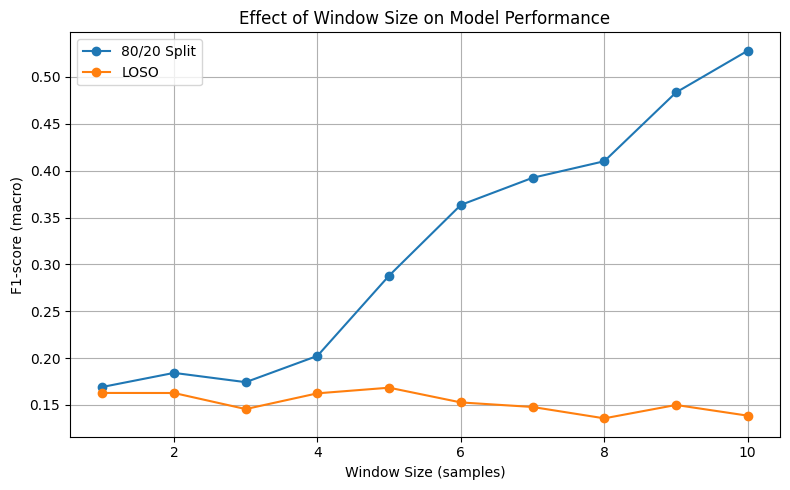

In [93]:
#Plot F1 Score vs Window Size

plt.figure(figsize=(8,5))
plt.plot(df_win_split["Window"], df_win_split["F1"], marker="o", label="80/20 Split")
plt.plot(df_win_loso["Window"], df_win_loso["F1"], marker="o", label="LOSO")
plt.xlabel("Window Size (samples)")
plt.ylabel("F1-score (macro)")
plt.title("Effect of Window Size on Model Performance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()